In [ ]:
# import the libraries
import random
import numpy as np
import pandas as pd
from functools import reduce
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
figsize = (20, 8)

In [ ]:
# Define the start and end date
start = datetime(2018, 1, 1)
end = datetime.today()

In [ ]:
# Now download some price data from Yahoo for various stock indexs for comparison.
# DJI=Dow Jones Industrial Average, IXIC=Nasdaq Composite, GSPC=Nasdaq DJI Composite, BSESN=SENSEX
tickers = ["^DJI", "^IXIC", "^GSPC", "^BSESN"]
asset_universe = pd.DataFrame([web.DataReader(ticker, "yahoo", start, end).loc[:, "Adj Close"] for ticker in tickers], index = tickers).T.fillna(method = "ffill")
asset_universe = asset_universe.iloc[1:]
asset_universe = asset_universe/asset_universe.iloc[0, :]

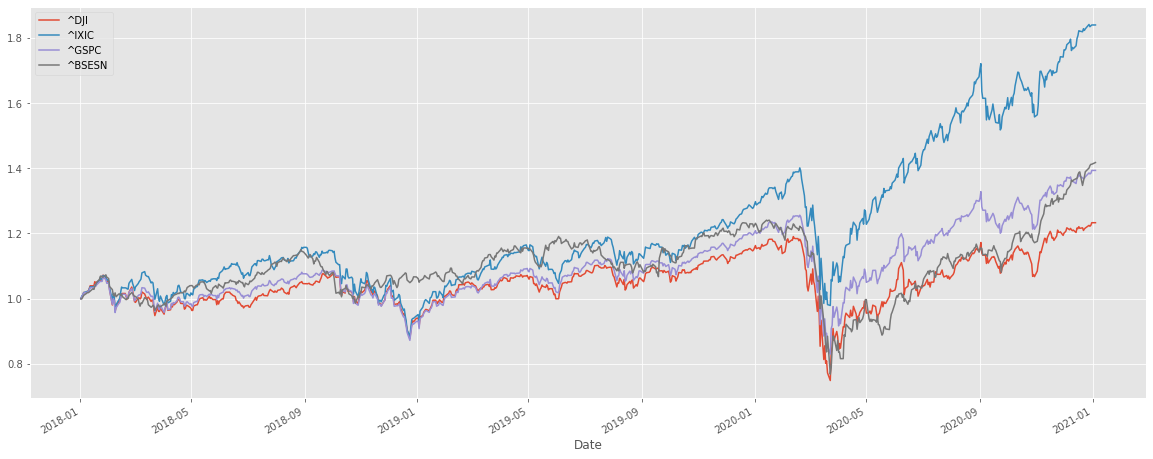

In [ ]:
# Plot the data
asset_universe.plot(figsize = figsize)

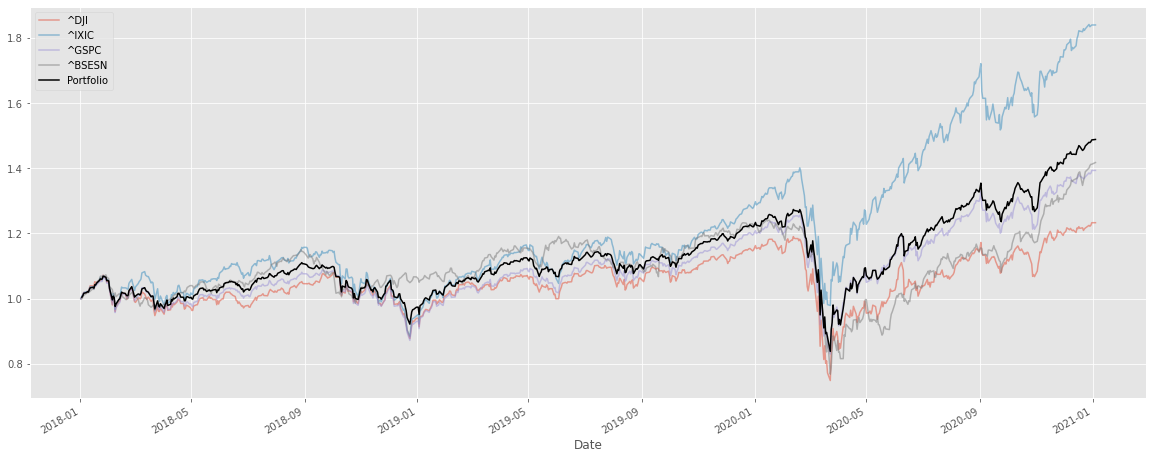

In [ ]:
# Create our equally weighted portfolio return series 
# plot the “price series” of our portfolio against the individual constituents
portfolio_returns = asset_universe.pct_change().dropna().mean(axis = 1)
portfolio = (asset_universe.pct_change().dropna().mean(axis = 1) + 1).cumprod()
asset_universe.plot(figsize = figsize, alpha = 0.5)
portfolio.plot(label = "Portfolio", color = "black")
plt.legend()

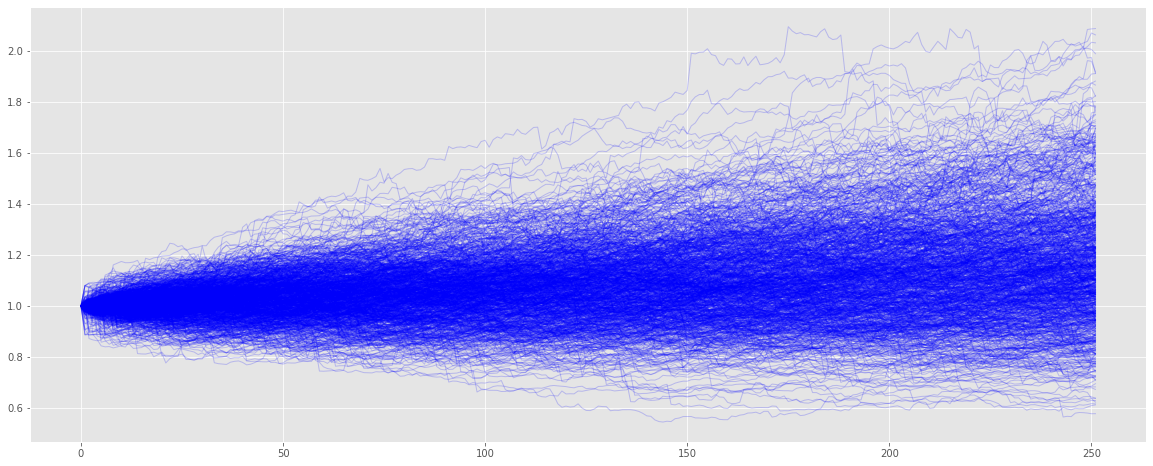

In [ ]:
# Let’s carry out the Bootstrapping process on our portfolio return series and plot the results(simulations)
portfolio_bootstrapping = (1 + pd.DataFrame([random.choices(list(portfolio_returns.values),
                                                            k = 252) for i in range(1000)]).T.shift(1).fillna(0)).cumprod()
portfolio_bootstrapping.plot(figsize = figsize, legend = False, linewidth = 1, alpha = 0.2, color = "b")

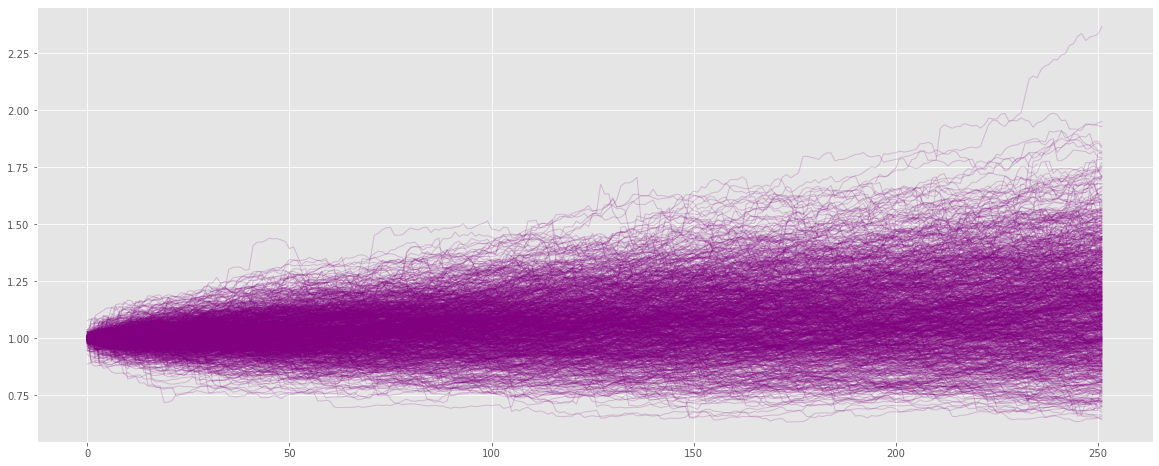

In [ ]:
# Let's take samples of our individual constituent returns series and use them to create our Bootstrapped simulations
asset_universe_returns = asset_universe.pct_change()
portfolio_constituents_bootstrapping = pd.DataFrame([((asset_universe_returns.iloc
                                                       [random.choices(range(len(asset_universe)), k = 252)]
                                                       ).mean(axis = 1) + 1).cumprod().values for x in range(1000)]).T
portfolio_constituents_bootstrapping.plot(figsize = figsize, legend = False, linewidth = 1, alpha = 0.2, color = "purple")

In [ ]:
# Finally use the parametric Monte Carlo method then compare the results between the various approaches
mu = portfolio_returns.mean()
sigma = portfolio_returns.std()
print(f"Our portfolio mean return value is {round(mu * 100, 2)}%")
print(f"Our portfolio standard deviation value is {round(sigma * 100, 2)}%")

Our portfolio mean return value is 0.06%
Our portfolio standard deviation value is 1.26%


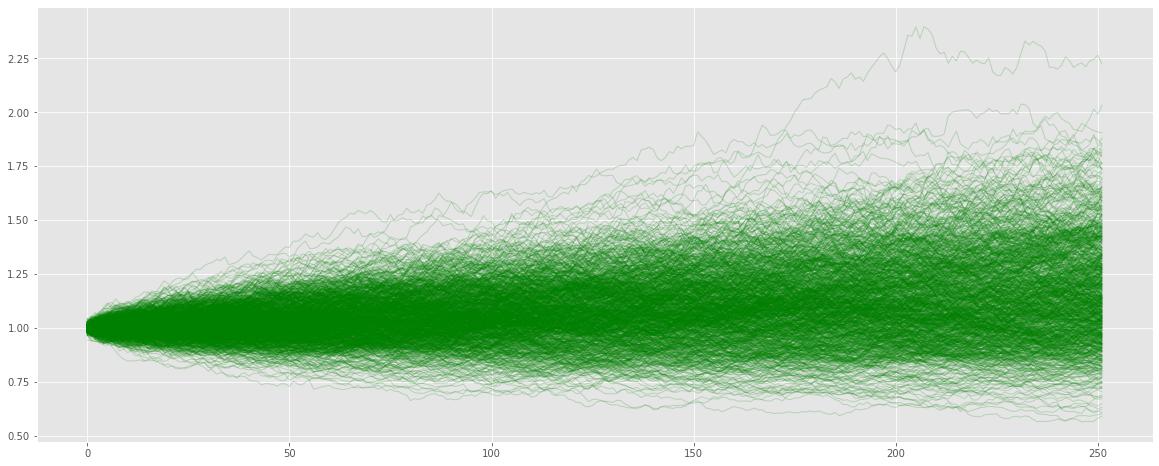

In [ ]:
# Now generate the necessary draws from the normal distribution with mean 0.04% and standard deviation 1.31%
portfolio_mc = pd.DataFrame([(np.random.normal(loc = mu, scale = sigma, size = 252) + 1) for x in range(1000)]).T.cumprod()
portfolio_mc.plot(figsize = figsize, legend = False, linewidth = 1, alpha = 0.2, color = "green")

In [ ]:
# Now run the Monte Carlo simulation approach but this time create random draws from each individual
# asset distribution and then construct our portfolio and see if there is any difference in outcome.
for asset in (asset_universe_returns.mean() * 100).round(2).index:
    print(f"The mean return for {asset} is {(asset_universe_returns.mean() * 100).round(2)[asset]}%")
    
print("\n")
for asset in (asset_universe_returns.std() * 100).round(2).index:
    print(f"The std  for {asset} is {(asset_universe_returns.std() * 100).round(2)[asset]}%")

The mean return for ^DJI is 0.04%
The mean return for ^IXIC is 0.09%
The mean return for ^GSPC is 0.05%
The mean return for ^BSESN is 0.05%


The std  for ^DJI is 1.54%
The std  for ^IXIC is 1.59%
The std  for ^GSPC is 1.45%
The std  for ^BSESN is 1.32%


In [ ]:
# Create DataFrames of simulated asset returns for each individual asset and store them in a list.
asset_returns_dfs = []
for asset in asset_universe_returns.mean().index:
    mu = asset_universe_returns.mean()[asset]
    sigma = asset_universe_returns.std()[asset]
    asset_mc_rets = pd.DataFrame([(np.random.normal(loc = mu, scale = sigma, size = 252)) for x in range(1000)]).T
    asset_returns_dfs.append(asset_mc_rets)

weighted_asset_returns_dfs = [(returns_df / len(tickers)) for returns_df in asset_returns_dfs]
weighted_asset_returns_dfs

[          0         1         2    ...       997       998       999
 0    0.003135  0.000614  0.003447  ...  0.006561  0.004406 -0.012649
 1   -0.000751 -0.005707  0.001623  ... -0.002897  0.001398  0.001481
 2    0.003629 -0.003613 -0.004535  ... -0.008406 -0.004990  0.003374
 3    0.003616 -0.001910 -0.004706  ... -0.000283 -0.000409  0.001775
 4   -0.002430 -0.003758  0.000239  ...  0.004761  0.001982  0.000509
 ..        ...       ...       ...  ...       ...       ...       ...
 247  0.004043 -0.001438 -0.003393  ... -0.005567 -0.002336 -0.000015
 248  0.005606  0.004660  0.007708  ...  0.001298  0.000146 -0.000266
 249  0.001253 -0.003327 -0.002752  ... -0.001748 -0.003699  0.000507
 250  0.005373 -0.005255  0.002669  ...  0.000176  0.004116  0.006570
 251  0.001291 -0.002618  0.004527  ... -0.002217 -0.003081 -0.005169
 
 [252 rows x 1000 columns],
           0         1         2    ...       997       998       999
 0    0.001906 -0.008591  0.000420  ... -0.004629  0.001248 

In [ ]:
# Add together the DataFrame values using the “reduce” function from the “functools” library 
portfolio_constituents_mc = (reduce(lambda x, y: x + y, weighted_asset_returns_dfs) + 1).cumprod()
portfolio_constituents_mc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,1.006640,0.992165,1.008905,0.998984,0.981676,0.995947,0.998588,0.998298,0.995713,0.998575,1.009411,1.004996,0.989790,1.013478,1.000057,1.001423,0.995520,1.000521,0.996191,0.994710,0.994361,1.000390,1.002515,1.015271,1.000466,1.002611,0.998019,0.992378,1.008452,1.000457,0.991682,1.007294,0.999143,0.994637,1.008463,0.995197,0.990858,1.016269,0.999374,0.989215,...,0.998195,0.995105,1.001263,0.998101,0.999205,1.011114,0.998312,1.000125,1.008766,0.987629,1.009275,1.013473,1.004616,0.993274,1.012225,0.996500,0.996949,0.999863,1.005165,0.997834,1.009337,0.994457,0.997687,1.008080,1.002003,1.000198,1.000961,1.003334,0.991327,0.991843,1.003051,1.007629,1.000580,0.993259,0.983604,1.007814,0.999891,1.004054,1.007229,0.983883
1,1.002863,0.984029,1.026008,1.012951,0.973180,0.985246,0.996098,0.998310,0.993937,0.997532,1.018903,1.009976,0.988074,1.019665,1.009469,0.998514,0.991441,0.998643,1.010507,1.000246,0.995529,0.991427,1.001498,1.026627,0.997854,1.006662,0.995982,1.003600,1.007376,0.999982,0.983436,1.007071,1.002033,0.997715,1.009526,0.995150,0.988804,1.010779,1.004163,0.991008,...,0.993368,0.985043,1.009105,1.001680,1.001204,1.012856,0.995338,1.006671,1.004495,0.990131,1.002427,1.010972,1.007663,0.988133,1.011279,1.002458,1.010019,1.006326,0.999060,0.998861,1.014963,0.995903,0.993013,1.022218,0.995791,1.014051,0.995463,1.002563,0.997664,0.989026,0.994968,1.014190,0.990602,1.003703,0.989272,1.010569,1.014469,1.005027,1.018972,0.990720
2,1.006535,0.985643,1.028503,1.011084,0.978228,0.987314,0.993109,0.999446,1.009038,0.979865,1.010686,1.015790,0.994591,1.024766,1.007676,0.996057,0.993420,0.978580,1.001941,1.007360,1.006602,0.993722,1.002726,1.029965,0.985403,1.010512,0.999504,1.006742,1.009234,1.007309,0.986958,1.013939,0.996790,0.993784,1.011008,0.982447,0.984458,1.010373,1.002498,0.999423,...,0.989999,0.979210,1.018313,1.000074,0.995086,1.009493,0.979900,0.994642,1.007444,0.987868,1.009056,1.011044,1.009087,0.993050,1.017469,0.993717,0.998804,0.993138,0.991650,0.998685,1.021335,1.007955,0.996463,1.015501,1.000442,1.016924,0.989383,1.002372,1.007179,0.995794,0.996778,0.998756,0.989529,1.000179,0.988434,1.015396,1.013496,0.996824,1.010898,0.990176
3,1.012140,0.975283,1.038231,1.011779,0.992429,0.984332,1.000103,1.001137,1.002956,0.974132,1.009692,1.024050,0.996737,1.023341,1.007076,0.985924,1.000742,0.978912,1.004949,1.007978,1.001845,0.985643,1.009299,1.023569,0.993491,1.009263,1.001161,1.011467,1.003374,1.002182,0.983789,1.006404,0.996068,0.996706,1.011872,0.988181,0.985308,1.004941,1.005326,1.006979,...,0.986411,0.979623,1.017491,1.004759,1.007900,1.011326,0.977879,0.991205,1.013071,0.981994,1.020953,1.013950,0.992964,0.998790,1.009769,1.001170,0.994797,0.999887,0.990989,0.997671,1.023885,1.010632,1.002222,1.019395,0.981499,1.003461,0.975722,1.005221,1.003305,0.991076,1.009690,0.997575,0.977117,0.992405,0.992783,1.014716,1.016345,0.997317,0.992965,1.002610
4,1.015257,0.967921,1.034445,1.012303,1.003558,0.987920,1.000833,0.999076,1.011530,0.968578,1.001235,1.025063,0.989826,1.026204,1.006073,0.980848,0.988224,0.981871,0.996945,1.006996,1.007183,0.973746,1.015466,1.036087,0.988724,1.010700,1.003425,1.012036,0.994050,1.001113,0.986236,1.003376,0.998410,1.000368,1.016216,0.988162,0.994094,0.984529,0.997198,1.007215,...,0.974094,0.978067,1.026559,1.007194,1.015657,1.009759,0.978034,1.005180,1.004740,0.975601,1.031879,1.009048,0.990450,0.989957,0.997855,1.001803,0.976922,1.006776,0.989324,1.007467,1.022617,1.024003,0.993988,1.023119,0.984382,1.010421,0.979378,1.008524,1.016431,0.999026,1.016035,1.007842,0.980355,0.997063,0.991500,1.014573,1.005141,0.992849,0.998924,1.000651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

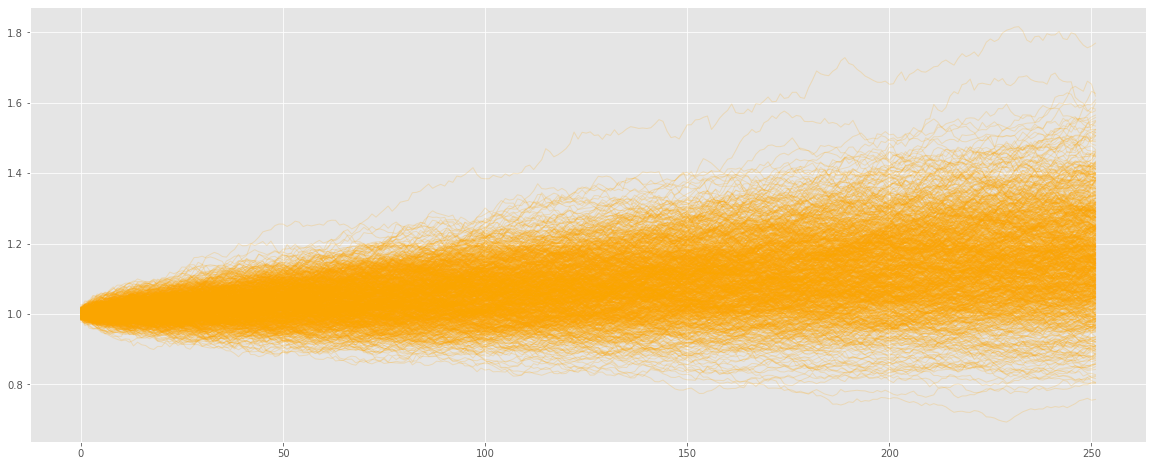

In [ ]:
# Finally we plot the resulting Monte Carlo portfolio value simulations
portfolio_constituents_mc.plot(figsize = figsize, legend = False, linewidth = 1, alpha = 0.2, color = "orange")

[]

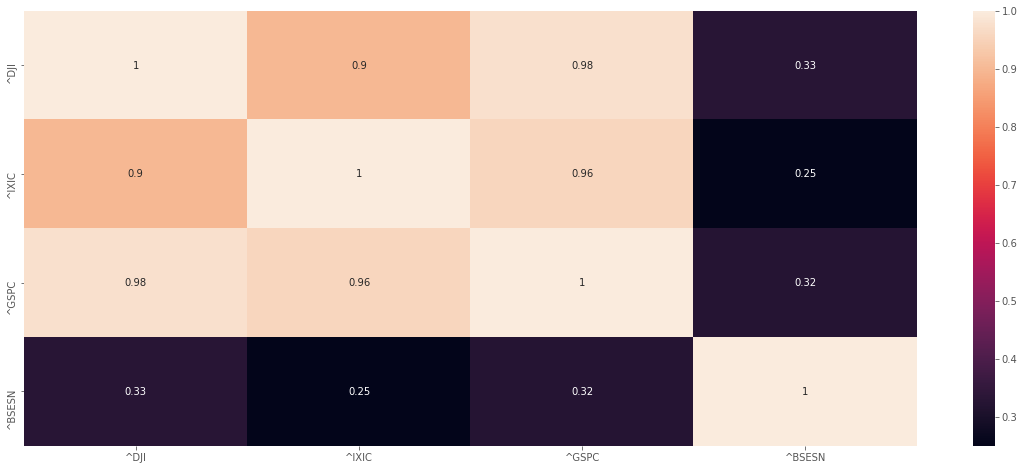

In [ ]:
# If you notice, all the previous simulations, whether Bootstrapping or Monte Carlo have all produce simulations 
# which fall within the ending value bounds of around 0.8 to 1.6 But in the last plot we see these bounds have 
# tightened to around 0.9 to 1.3.take a quick look at the historic correlations between the constituent assets
# returns in the asset universe. Let’s create a nice looking little correlation heatmap to have a look.
ax, fig = plt.subplots(figsize = figsize)
sns.heatmap(asset_universe_returns.corr(),annot = True)
plt.plot()

In [ ]:
# Looking at the above values, we can see that all of the assets are positively correlated to some degree, some more than others, bit importantly the values are all positive.
# This goes a long way to explaining why our last plot and out last simulation method (the parametric Monte Carlo simulations on constituent assets that were then weighted and 
# summed to represent our portfolio) resulted in a more narrow range of ending values.